In [1]:
!pip -q install imbalanced-learn xgboost shap

In [2]:
import os, sys, glob, warnings, textwrap, numpy as np, pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import shap, joblib
shap.__version__
RANDOM_STATE = 42

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True
sns.set_context("notebook")


In [3]:
import pandas as pd

CSV_PATH = "Churn_Modeling.csv"
df = pd.read_csv("/content/Churn_Modeling.csv")

print(f"Loaded: {CSV_PATH} | shape: {df.shape}")
display(df.head())


Loaded: Churn_Modeling.csv | shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Head:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Target column detected: Exited
Dropping ID-like columns: ['RowNumber', 'CustomerId', 'Surname']


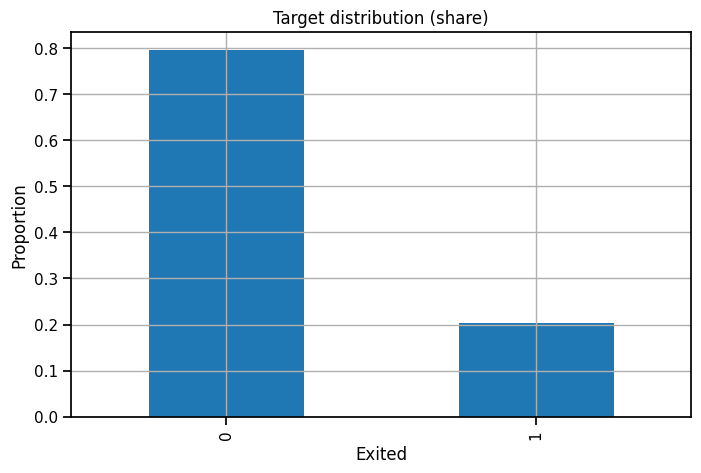

In [4]:
print(df.info())
print("\nHead:")
display(df.head())

# Guess the target column robustly
TARGET_CANDIDATES = ["Exited", "Churn", "churn", "Target", "y"]
target = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target = c
        break
if target is None:
    raise ValueError("Target column not found. Make sure your file has an 'Exited' (or similar) column.")

print("\nTarget column detected:", target)

# Drop common ID-like columns if present
ID_COLS = {"RowNumber","CustomerId","Surname","id","customerid","name","CustomerID","AccountNumber"}
to_drop = [c for c in df.columns if c in ID_COLS]
print("Dropping ID-like columns:", to_drop)
df = df.drop(columns=to_drop)

# Basic target distribution
ax = df[target].value_counts(normalize=True).sort_index().plot(kind="bar")
ax.set_title("Target distribution (share)")
ax.set_xlabel(target)
ax.set_ylabel("Proportion")
plt.show()


In [5]:
y = df[target].astype(int)
X = df.drop(columns=[target])

# Identify column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Geography', 'Gender']


((8000, 10), (2000, 10))

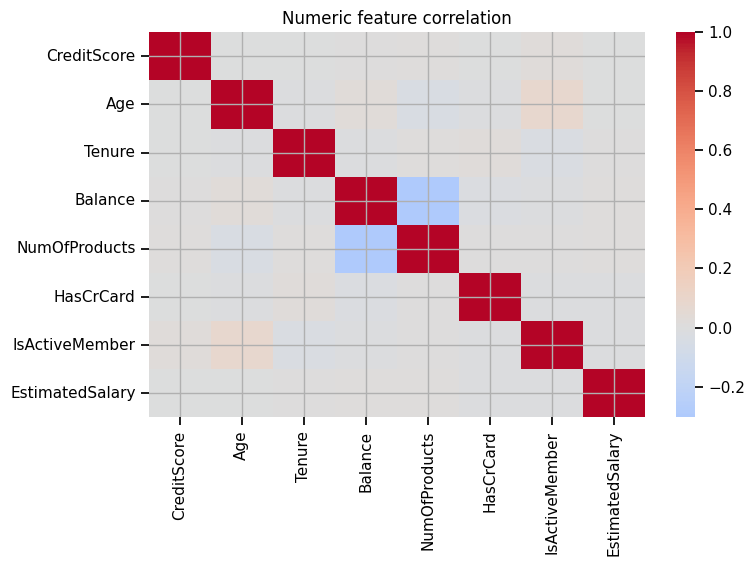

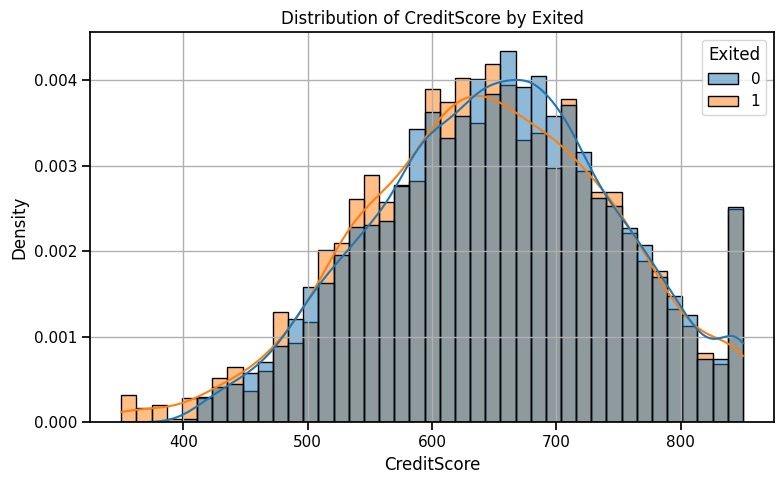

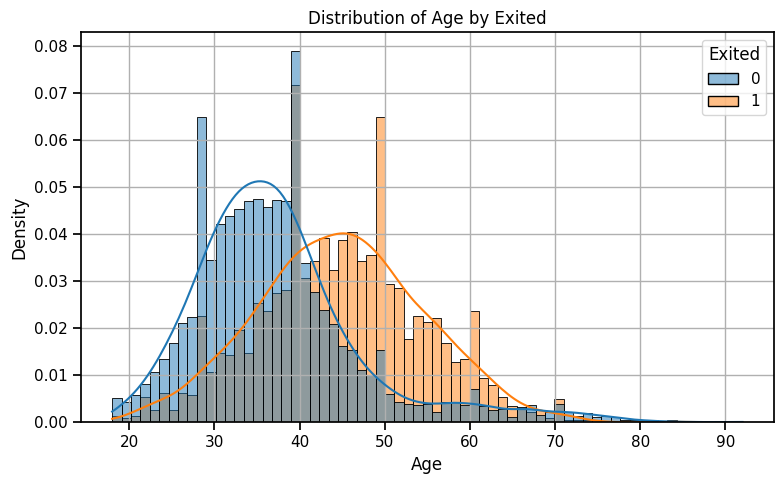

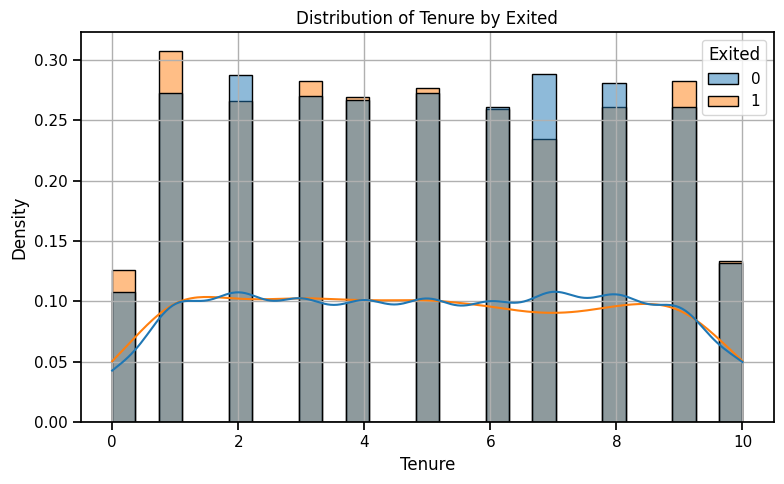

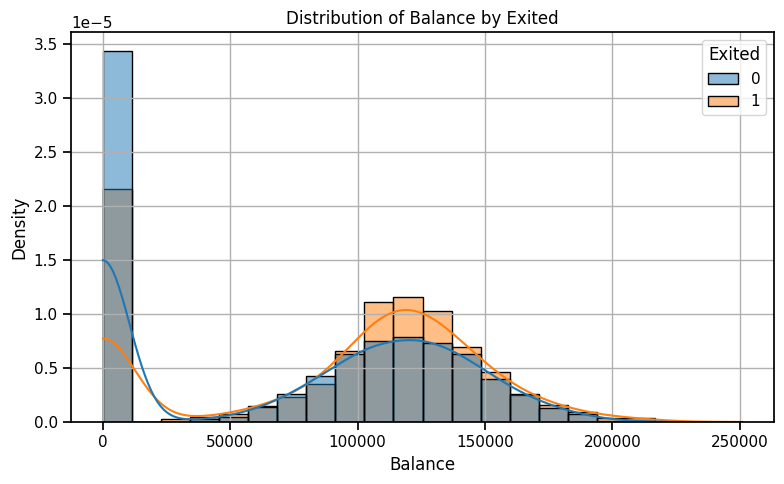

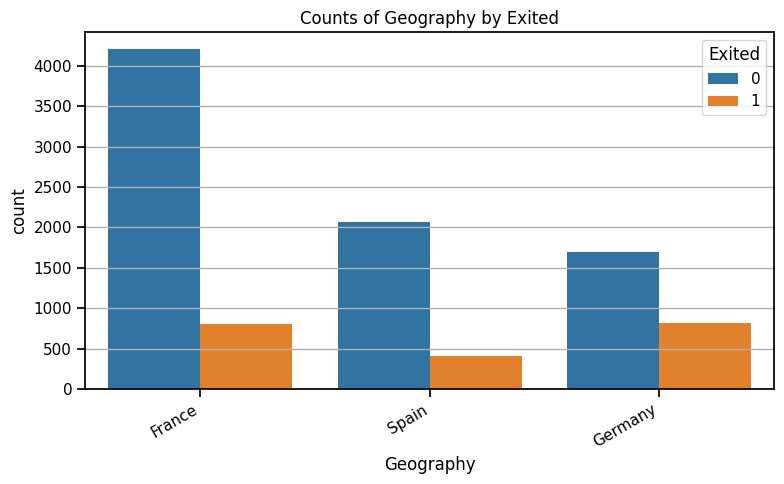

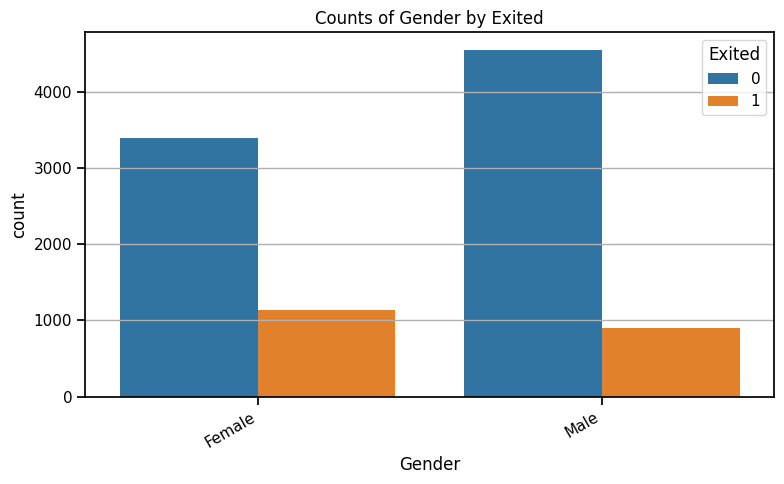

In [6]:
# Correlation on numeric columns
if len(num_cols) > 1:
    corr = X[num_cols].corr()
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Numeric feature correlation")
    plt.show()

# some distributions
cols_to_plot = (num_cols[:4] if len(num_cols) >= 4 else num_cols) + (cat_cols[:2] if len(cat_cols)>=2 else cat_cols)
for c in cols_to_plot:
    plt.figure()
    if c in num_cols:
        sns.histplot(data=df, x=c, hue=target, kde=True, stat="density", common_norm=False)
        plt.title(f"Distribution of {c} by {target}")
    else:
        sns.countplot(data=df, x=c, hue=target)
        plt.title(f"Counts of {c} by {target}")
        plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [8]:

ohe_kwargs = dict(drop="first", handle_unknown="ignore")
try:
    ohe = OneHotEncoder(sparse_output=True, **ohe_kwargs)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(sparse=True, **ohe_kwargs)         # sklearn < 1.2

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# Helper to fetch transformed feature names
def get_feature_names(fitted_preproc, num_cols=num_cols, cat_cols=cat_cols):
    names = []
    if num_cols:
        names.extend(list(num_cols))
    if cat_cols:
        ohe_fitted = fitted_preproc.named_transformers_["cat"].named_steps["ohe"]
        # Trying new API first
        if hasattr(ohe_fitted, "get_feature_names_out"):
            names.extend(list(ohe_fitted.get_feature_names_out(cat_cols)))
        else:
            names.extend(list(ohe_fitted.get_feature_names(cat_cols)))
    return np.array(names)


In [9]:
def evaluate_classifier(clf, X_tr, y_tr, X_te, y_te, label="model"):
    y_hat = clf.predict(X_te)
    y_prob = None
    try:
        y_prob = clf.predict_proba(X_te)[:, 1]
    except Exception:
        try:
            y_prob = clf.decision_function(X_te)
        except Exception:
            pass

    metrics = {
        "model": label,
        "accuracy": accuracy_score(y_te, y_hat),
        "precision": precision_score(y_te, y_hat, zero_division=0),
        "recall": recall_score(y_te, y_hat, zero_division=0),
        "f1": f1_score(y_te, y_hat, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan
    }

    print(f"\n=== {label} ===")
    print(pd.Series(metrics))
    print("\nClassification Report:\n", classification_report(y_te, y_hat, zero_division=0))

    cm = confusion_matrix(y_te, y_hat)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {label}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_te, y_prob)
        plt.title(f"ROC Curve — {label}")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_te, y_prob)
        plt.title(f"Precision-Recall Curve — {label}")
        plt.show()

    return metrics


In [10]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "SVC": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=4,
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGB": XGBClassifier(
        n_estimators=400, max_depth=5, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, random_state=RANDOM_STATE, eval_metric="logloss", n_jobs=-1
    )
}



=== LogReg_plain ===
model        LogReg_plain
accuracy            0.808
precision        0.589147
recall           0.186732
f1               0.283582
roc_auc          0.774787
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



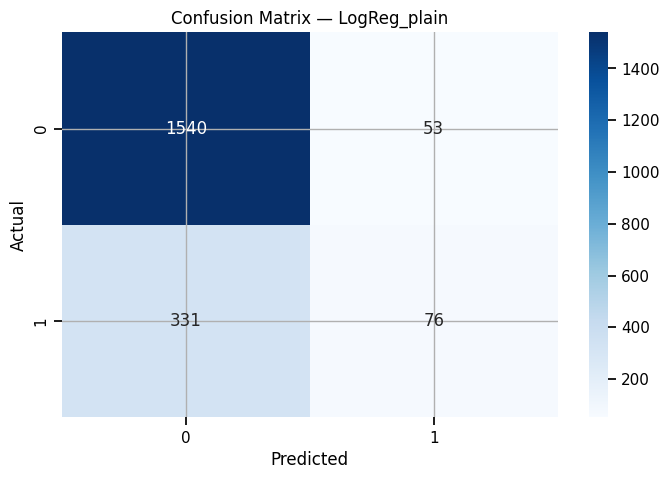

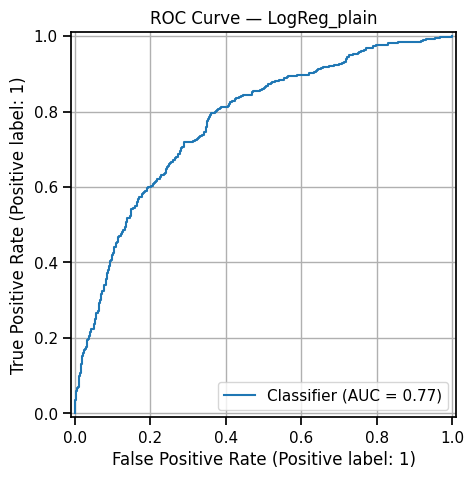

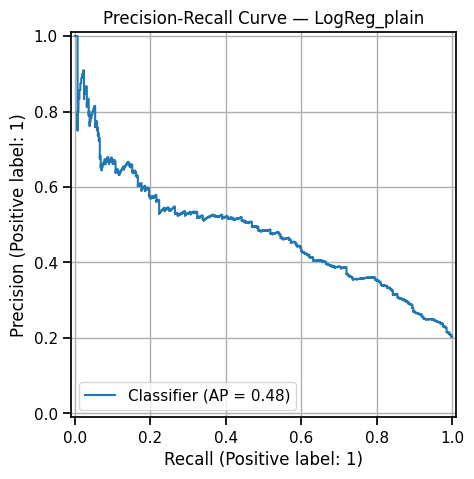


=== KNN_plain ===
model        KNN_plain
accuracy         0.841
precision     0.776398
recall        0.307125
f1            0.440141
roc_auc       0.825783
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1593
           1       0.78      0.31      0.44       407

    accuracy                           0.84      2000
   macro avg       0.81      0.64      0.67      2000
weighted avg       0.83      0.84      0.81      2000



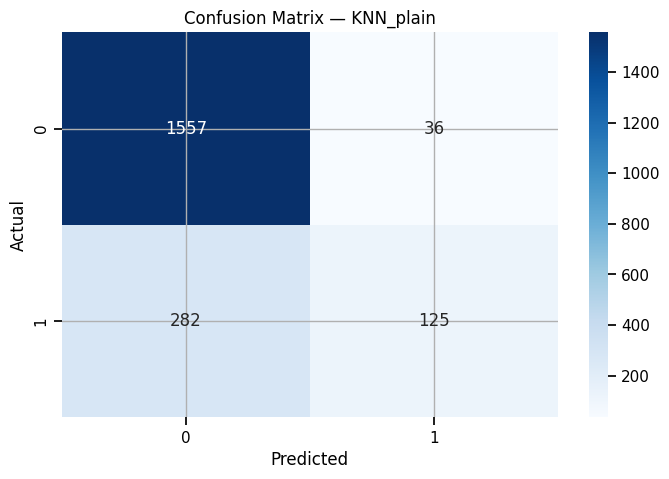

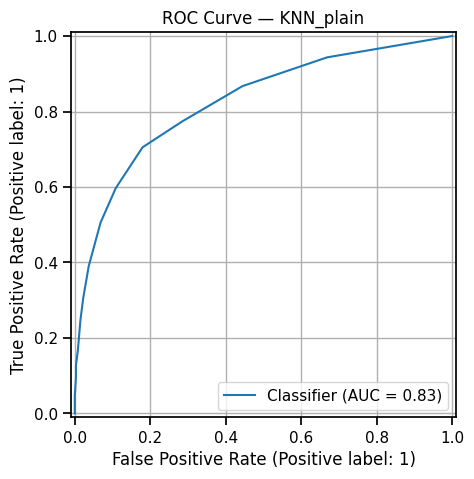

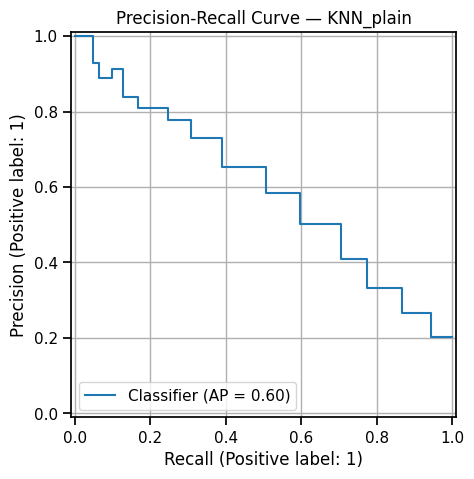


=== SVC_plain ===
model        SVC_plain
accuracy         0.854
precision     0.861635
recall        0.336609
f1            0.484099
roc_auc       0.822527
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      1593
           1       0.86      0.34      0.48       407

    accuracy                           0.85      2000
   macro avg       0.86      0.66      0.70      2000
weighted avg       0.86      0.85      0.83      2000



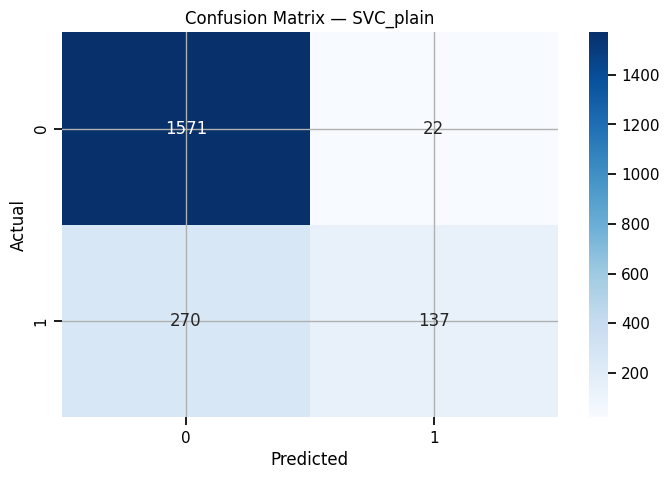

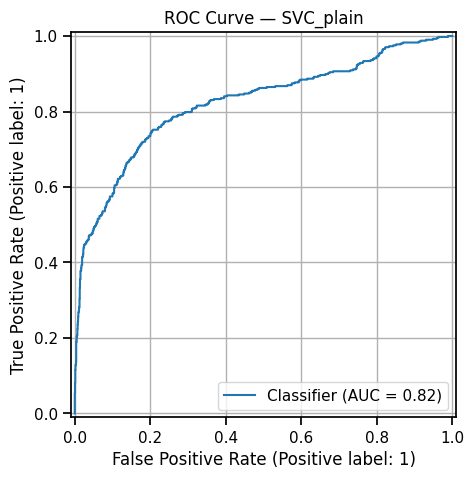

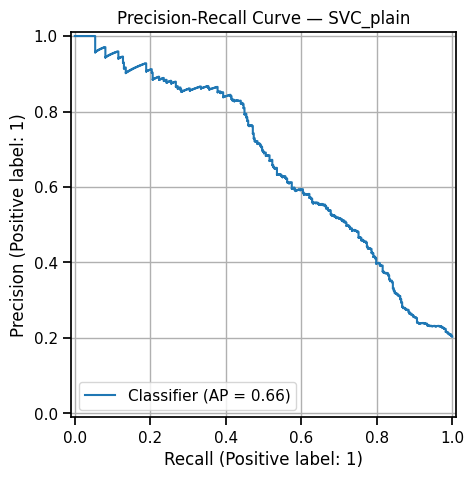


=== RF_plain ===
model        RF_plain
accuracy        0.868
precision    0.794239
recall       0.474201
f1           0.593846
roc_auc      0.858149
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



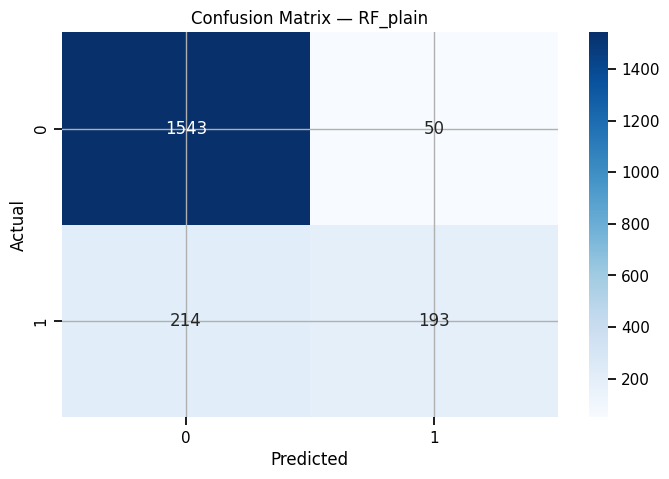

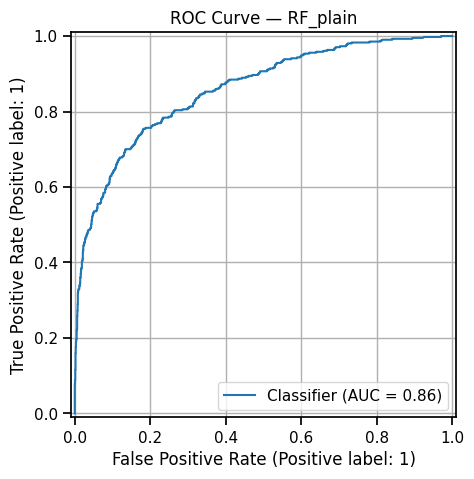

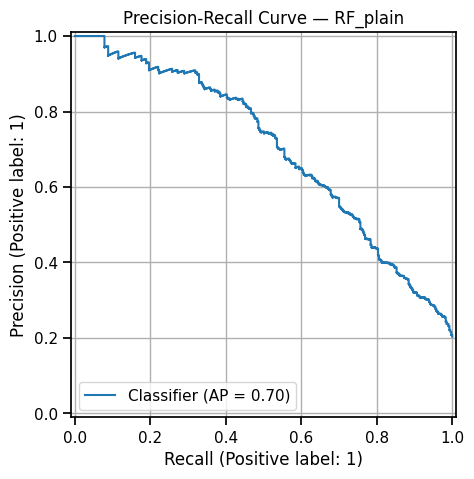


=== GB_plain ===
model        GB_plain
accuracy         0.87
precision    0.792829
recall       0.488943
f1           0.604863
roc_auc      0.870831
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



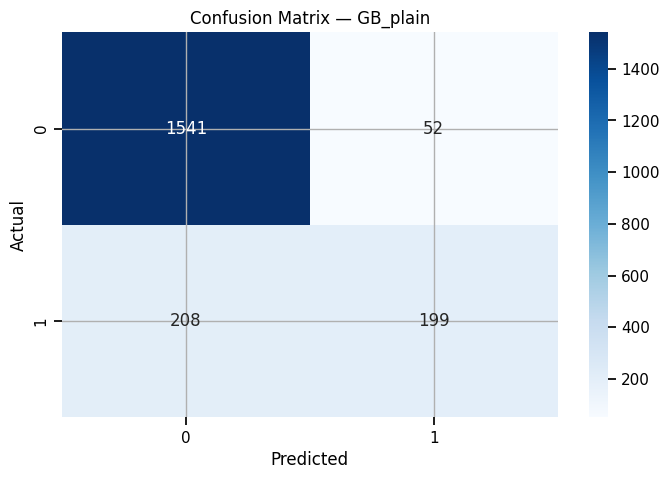

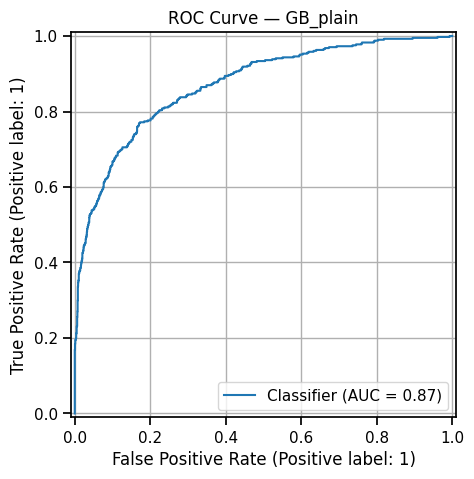

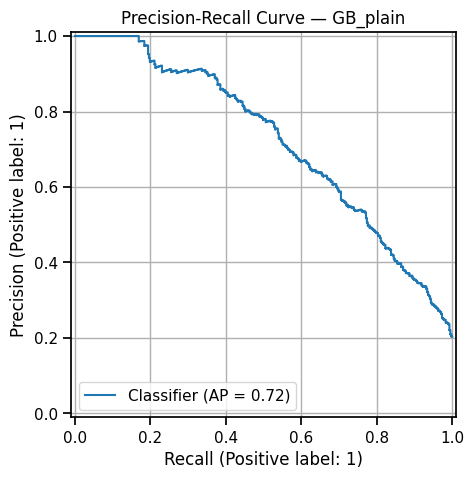


=== XGB_plain ===
model        XGB_plain
accuracy         0.863
precision     0.756757
recall        0.481572
f1            0.588589
roc_auc       0.857068
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.76      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



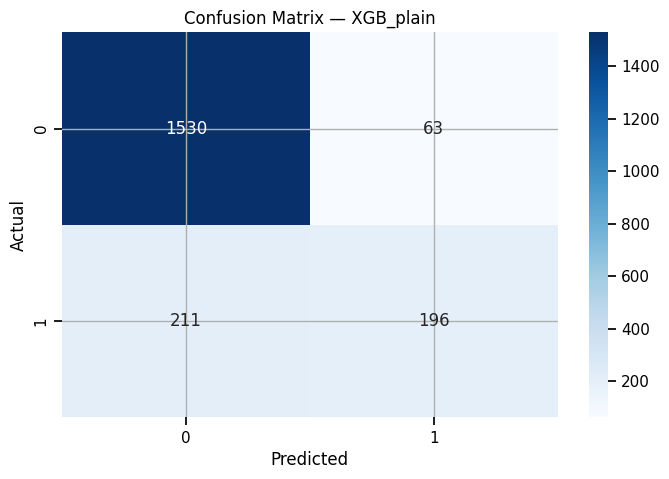

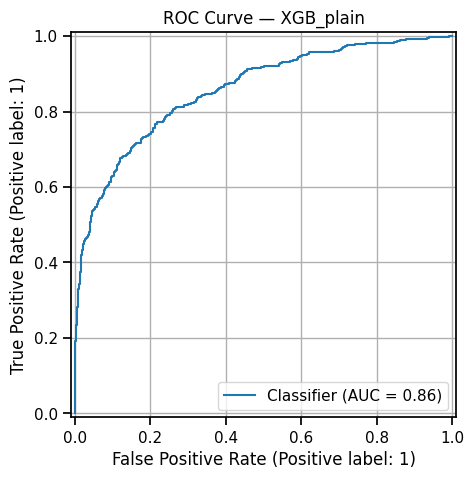

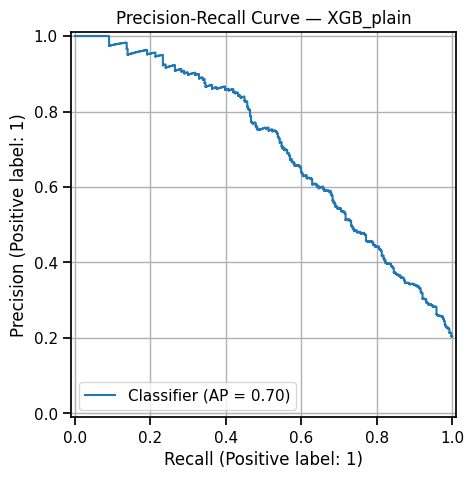

,accuracy,precision,recall,f1,roc_auc
model,,,,,
GB_plain,0.870,0.792829,0.488943,0.604863,0.870831
RF_plain,0.868,0.794239,0.474201,0.593846,0.858149
XGB_plain,0.863,0.756757,0.481572,0.588589,0.857068
SVC_plain,0.854,0.861635,0.336609,0.484099,0.822527
KNN_plain,0.841,0.776398,0.307125,0.440141,0.825783
LogReg_plain,0.808,0.589147,0.186732,0.283582,0.774787


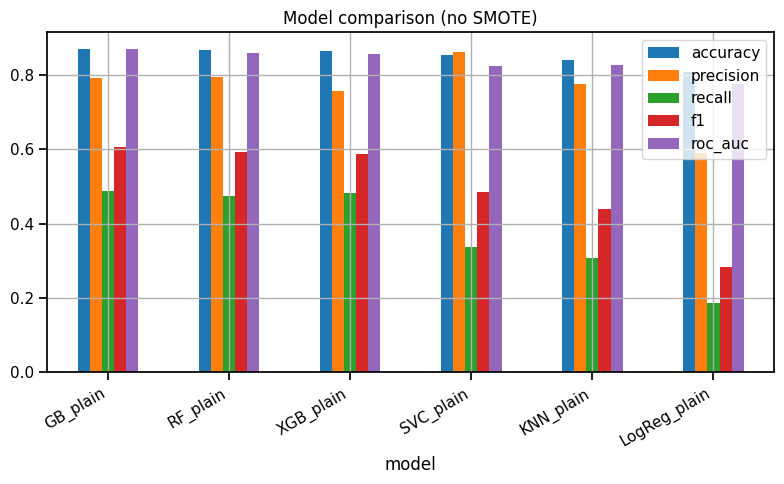

In [11]:
results_plain = []
for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", model)])
    pipe.fit(X_train, y_train)
    metrics = evaluate_classifier(pipe, X_train, y_train, X_test, y_test, label=f"{name}_plain")
    results_plain.append(metrics)

df_plain = pd.DataFrame(results_plain).set_index("model").sort_values("f1", ascending=False)
display(df_plain)

ax = df_plain[["accuracy","precision","recall","f1","roc_auc"]].plot(kind="bar")
ax.set_title("Model comparison (no SMOTE)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



=== LogReg_SMOTE ===
model        LogReg_SMOTE
accuracy           0.7205
precision        0.394444
recall           0.697789
f1               0.503993
roc_auc          0.774645
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.72      0.74      2000



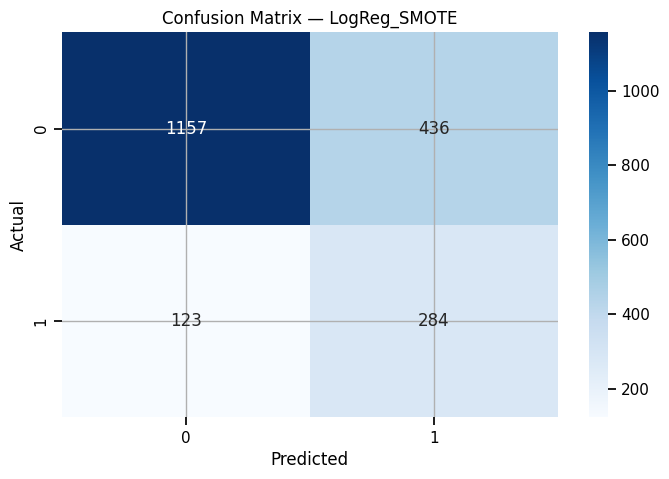

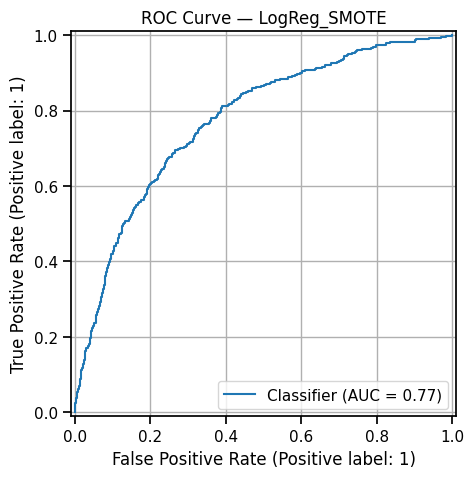

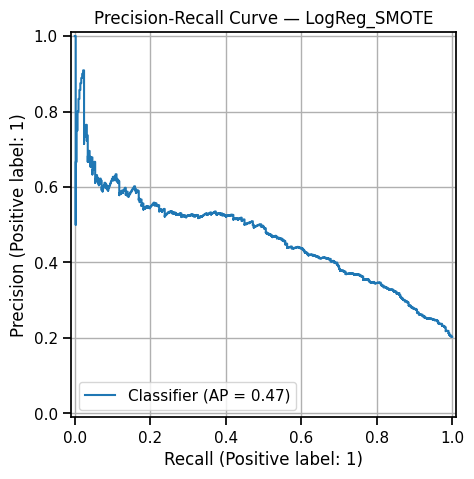


=== KNN_SMOTE ===
model        KNN_SMOTE
accuracy         0.752
precision     0.435036
recall        0.732187
f1            0.545788
roc_auc       0.817507
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      1593
           1       0.44      0.73      0.55       407

    accuracy                           0.75      2000
   macro avg       0.68      0.74      0.69      2000
weighted avg       0.82      0.75      0.77      2000



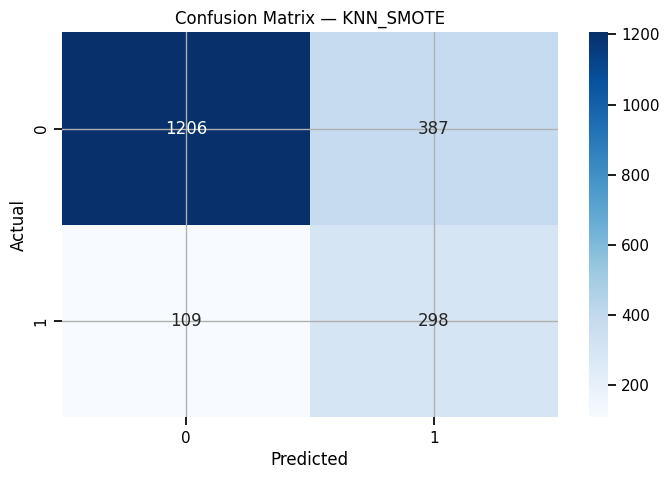

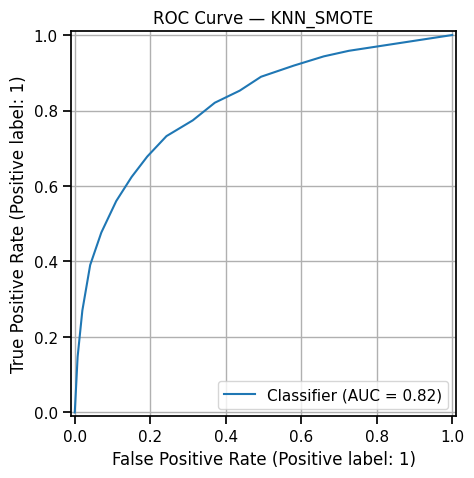

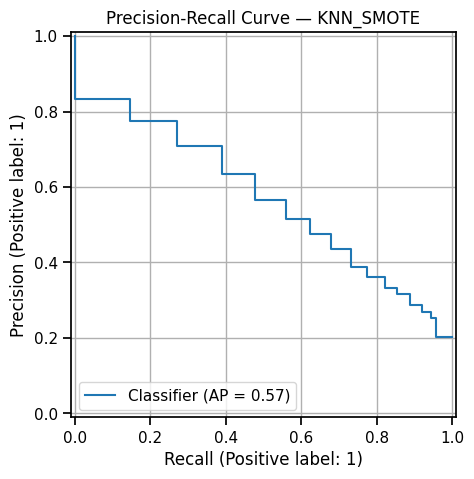


=== SVC_SMOTE ===
model        SVC_SMOTE
accuracy        0.7865
precision     0.483819
recall        0.734644
f1            0.583415
roc_auc       0.853533
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.48      0.73      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.79      0.80      2000



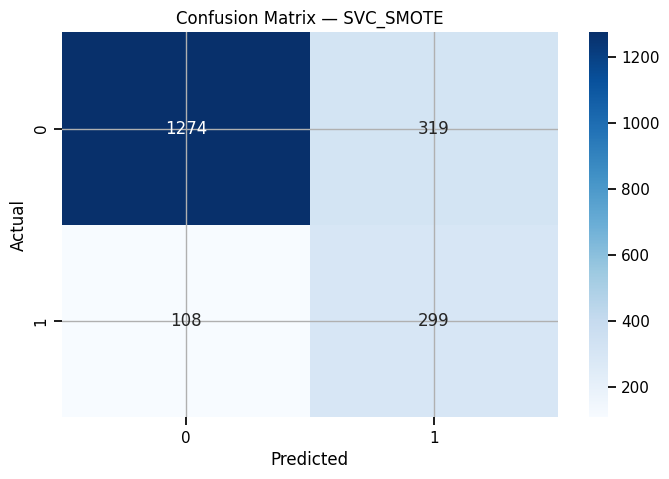

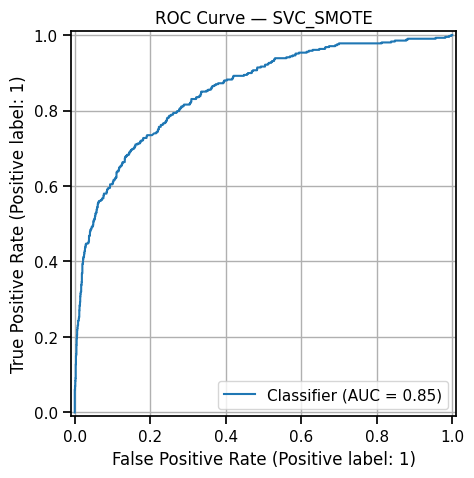

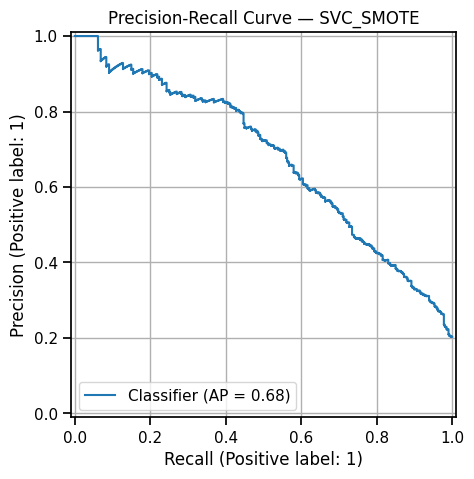


=== RF_SMOTE ===
model        RF_SMOTE
accuracy       0.8505
precision    0.647541
recall        0.58231
f1           0.613195
roc_auc      0.850833
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.65      0.58      0.61       407

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



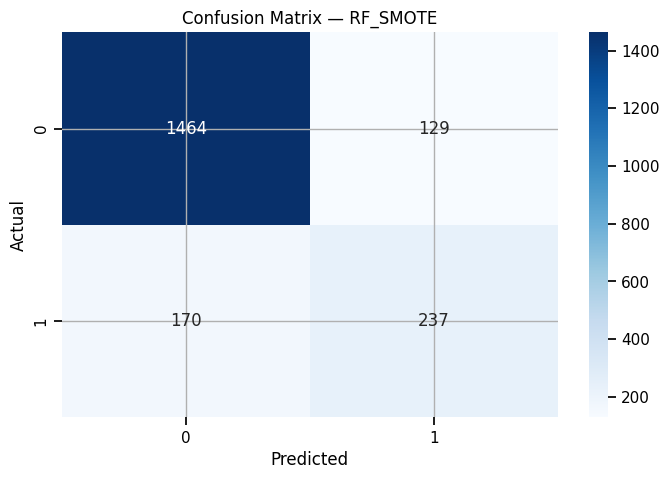

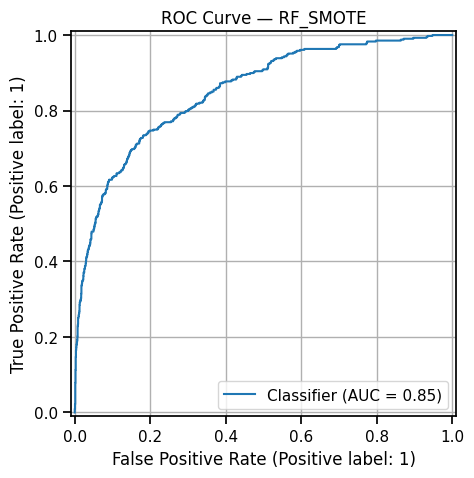

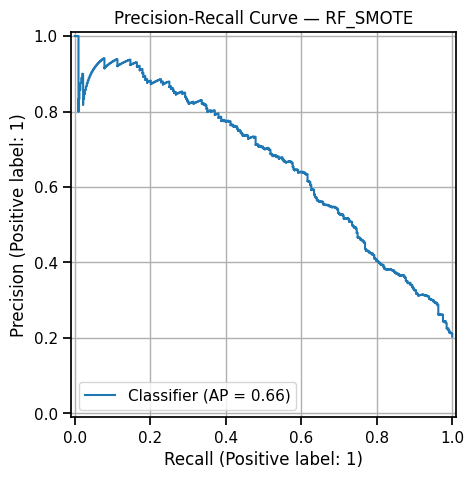


=== GB_SMOTE ===
model        GB_SMOTE
accuracy        0.843
precision    0.606407
recall       0.651106
f1           0.627962
roc_auc      0.865648
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.61      0.65      0.63       407

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.85      0.84      0.85      2000



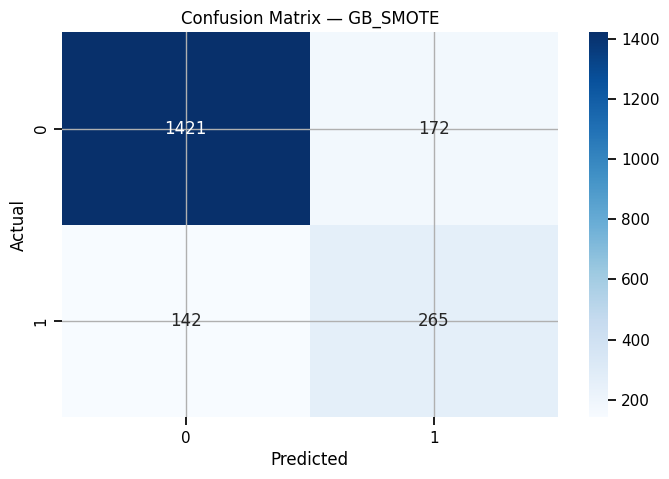

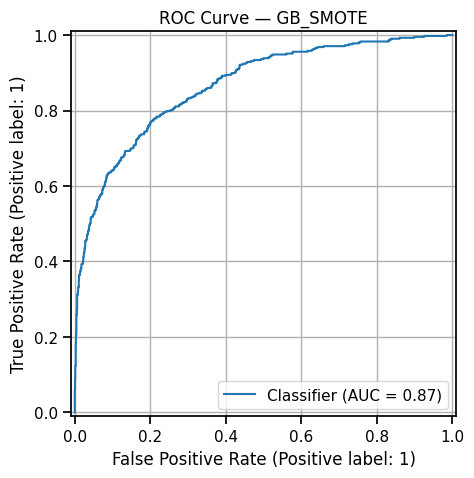

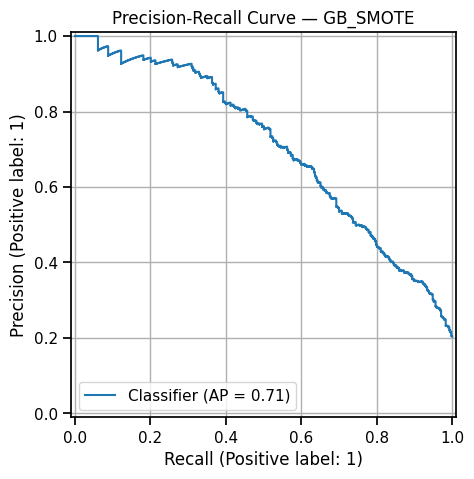


=== XGB_SMOTE ===
model        XGB_SMOTE
accuracy        0.8605
precision     0.689349
recall        0.572482
f1            0.625503
roc_auc       0.862755
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1593
           1       0.69      0.57      0.63       407

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.86      2000



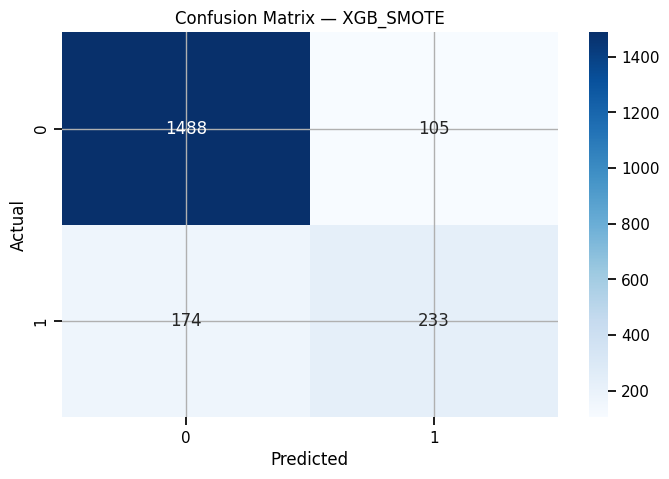

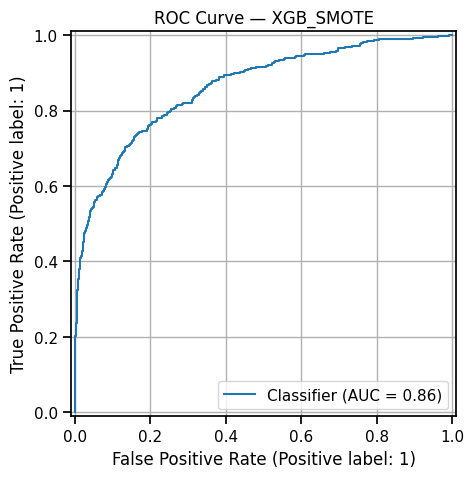

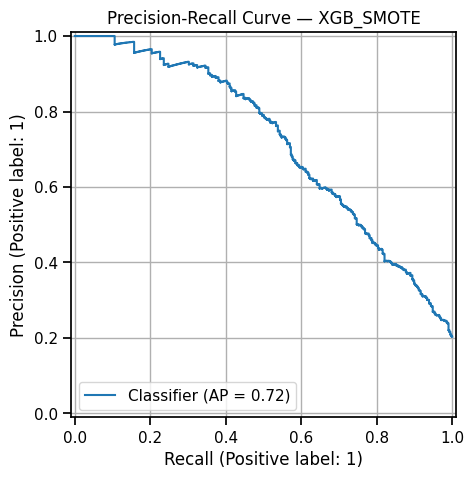

,accuracy,precision,recall,f1,roc_auc
model,,,,,
GB_SMOTE,0.8430,0.606407,0.651106,0.627962,0.865648
XGB_SMOTE,0.8605,0.689349,0.572482,0.625503,0.862755
RF_SMOTE,0.8505,0.647541,0.582310,0.613195,0.850833
SVC_SMOTE,0.7865,0.483819,0.734644,0.583415,0.853533
KNN_SMOTE,0.7520,0.435036,0.732187,0.545788,0.817507
LogReg_SMOTE,0.7205,0.394444,0.697789,0.503993,0.774645


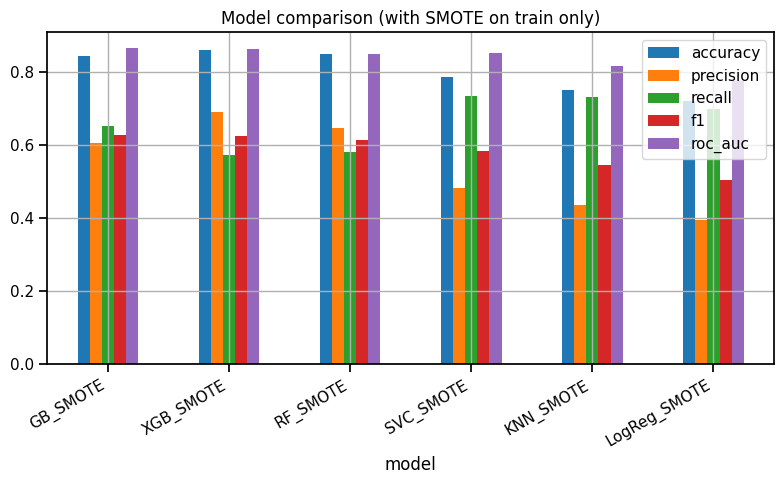

In [12]:
results_smote = []
for name, model in models.items():
    smote_pipe = ImbPipeline(steps=[
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", model)
    ])
    smote_pipe.fit(X_train, y_train)
    metrics = evaluate_classifier(smote_pipe, X_train, y_train, X_test, y_test, label=f"{name}_SMOTE")
    results_smote.append(metrics)

df_smote = pd.DataFrame(results_smote).set_index("model").sort_values("f1", ascending=False)
display(df_smote)

ax = df_smote[["accuracy","precision","recall","f1","roc_auc"]].plot(kind="bar")
ax.set_title("Model comparison (with SMOTE on train only)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Best (by F1) from SMOTE runs: GB_SMOTE
5-fold CV F1 mean ± std: 0.6191 ± 0.0292

=== GB_SMOTE(final) ===
model        GB_SMOTE(final)
accuracy               0.843
precision           0.606407
recall              0.651106
f1                  0.627962
roc_auc             0.865648
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.61      0.65      0.63       407

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.85      0.84      0.85      2000



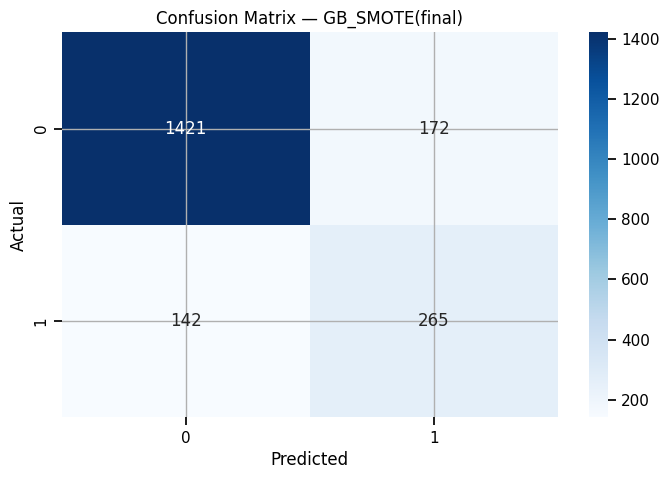

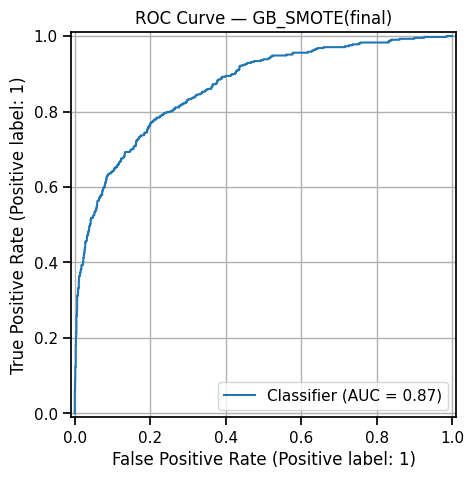

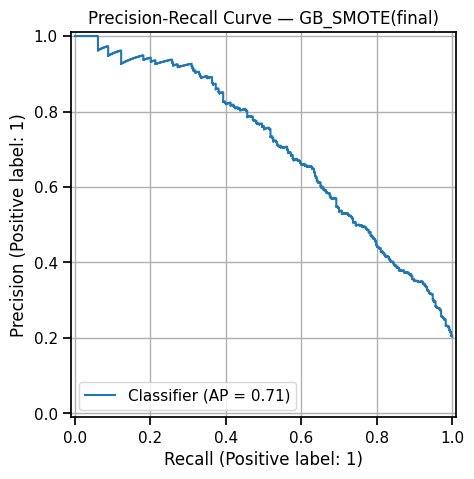

In [13]:
best_label = df_smote["f1"].idxmax()
print("Best (by F1) from SMOTE runs:", best_label)

# Extract base key
base_key = best_label.split("_")[0]
best_model = models[base_key]

best_pipe = ImbPipeline(steps=[("pre", preprocessor),
                               ("smote", SMOTE(random_state=RANDOM_STATE)),
                               ("clf", best_model)])
scores = cross_val_score(best_pipe, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
print("5-fold CV F1 mean ± std:", scores.mean().round(4), "±", scores.std().round(4))

best_pipe.fit(X_train, y_train)
_ = evaluate_classifier(best_pipe, X_train, y_train, X_test, y_test, label=f"{base_key}_SMOTE(final)")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'clf__n_estimators': 150, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 1, 'clf__max_samples': 0.6, 'clf__max_features': 'sqrt', 'clf__max_depth': 8}
Best CV F1: 0.6162

=== RF_SMOTE(tuned_fast) ===
model        RF_SMOTE(tuned_fast)
accuracy                   0.8345
precision                0.578189
recall                   0.690418
f1                       0.629339
roc_auc                  0.860788
dtype: object

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1593
           1       0.58      0.69      0.63       407

    accuracy                           0.83      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.85      0.83      0.84      2000



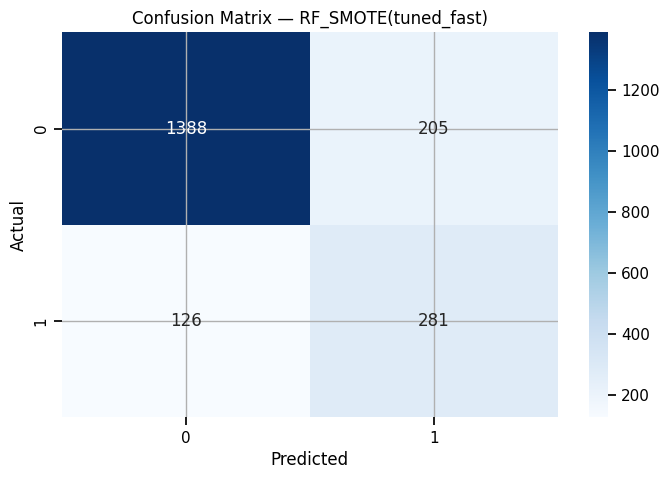

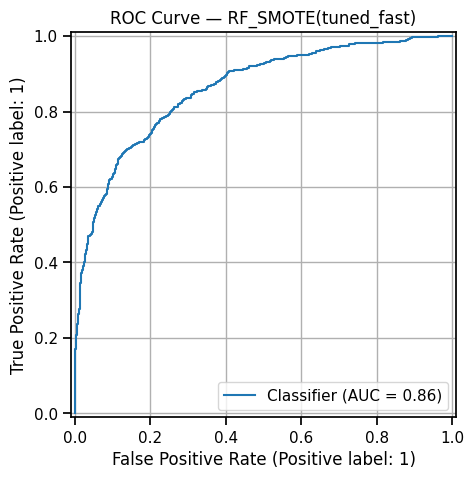

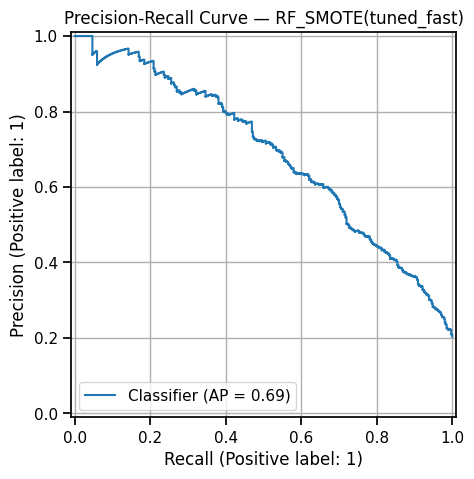

In [15]:


from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Pipeline: preprocessing + SMOTE + RF
rf_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# Lightweight search space (good balance of quality/speed)
param_distributions = {
    "clf__n_estimators":    [150, 250, 350, 450],
    "clf__max_depth":       [None, 6, 8, 10],
    "clf__min_samples_split":[2, 4, 6, 8],
    "clf__min_samples_leaf":[1, 2, 3],
    "clf__max_features":    ["sqrt", "log2", None],
    # Subsample for speed without much loss
    "clf__max_samples":     [None, 0.8, 0.6],
}

rs = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=18,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV F1:", round(rs.best_score_, 4))

rf_best = rs.best_estimator_
_ = evaluate_classifier(rf_best, X_train, y_train, X_test, y_test, label="RF_SMOTE(tuned_fast)")


In [16]:
preprocessor_fit = preprocessor.fit(X_train, y_train)
feature_names = get_feature_names(preprocessor_fit)
print("Transformed feature count:", len(feature_names))
feature_names[:15]


Transformed feature count: 11


array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male'],
      dtype='<U17')

,feature,importance
1,Age,0.314657
4,NumOfProducts,0.209855
8,Geography_Germany,0.133922
10,Gender_Male,0.092874
3,Balance,0.076305
6,IsActiveMember,0.047232
9,Geography_Spain,0.040973
2,Tenure,0.030090
7,EstimatedSalary,0.026349
0,CreditScore,0.023963


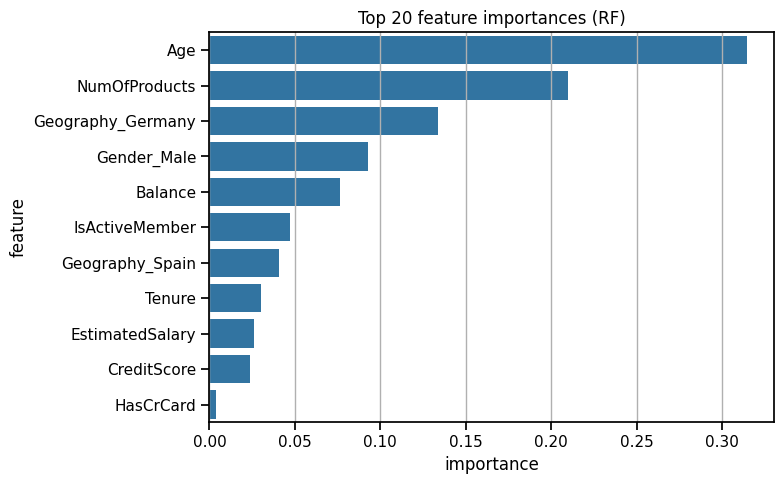

In [17]:

rf_for_importance = None
if "rf_best" in globals():
    rf_for_importance = rf_best
else:
    if base_key == "RF":
        rf_for_importance = best_pipe
    else:
        temp_rf = ImbPipeline(steps=[("pre", preprocessor),
                                     ("smote", SMOTE(random_state=RANDOM_STATE)),
                                     ("clf", RandomForestClassifier(
                                         n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))])
        temp_rf.fit(X_train, y_train)
        rf_for_importance = temp_rf

inner_rf = rf_for_importance.named_steps["clf"]
importances = inner_rf.feature_importances_

imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
display(imp_df.head(20))

sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 feature importances (RF)")
plt.tight_layout()
plt.show()


Transformed shapes — train: (8000, 11) | test: (2000, 11) | features: 11


100%|===================| 3997/4000 [01:32<00:00]       

SHAP values shape: (2000, 11, 2)
X_test_dense shape: (2000, 11)


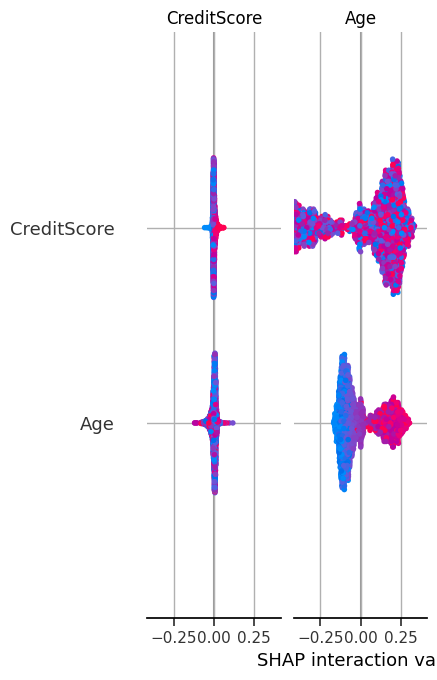

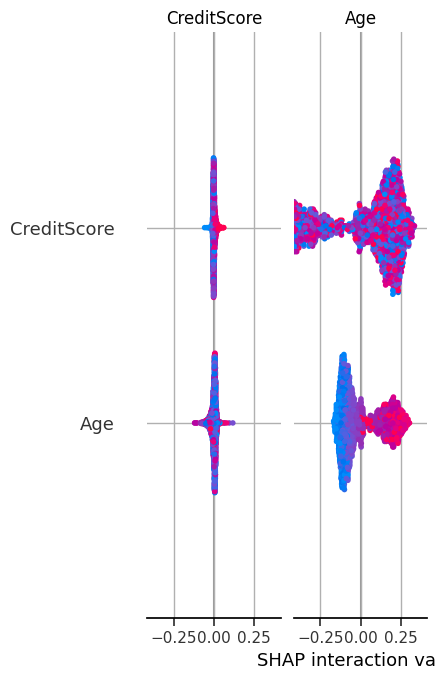

In [19]:
import numpy as np
import shap

def to_dense(M):
    return M.toarray() if hasattr(M, "toarray") else np.asarray(M)


rf_pipe_used = rf_for_importance
model = rf_pipe_used.named_steps["clf"]


preproc_used = rf_pipe_used.named_steps["pre"]


X_train_trans = preproc_used.transform(X_train)
X_test_trans  = preproc_used.transform(X_test)

X_train_dense = to_dense(X_train_trans)
X_test_dense  = to_dense(X_test_trans)


feature_names = get_feature_names(preproc_used)
print("Transformed shapes — train:", X_train_dense.shape, "| test:", X_test_dense.shape, "| features:", len(feature_names))

# Background sample for stability/speed
rng = np.random.RandomState(42)
bg_n = min(200, X_train_dense.shape[0])
bg_idx = rng.choice(np.arange(X_train_dense.shape[0]), size=bg_n, replace=False)
background = X_train_dense[bg_idx]


try:
    explainer = shap.TreeExplainer(model, data=background, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test_dense)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]
except Exception as e:
    print("TreeExplainer fallback due to:", e)
    explainer = shap.Explainer(model, background)
    shap_values = explainer(X_test_dense).values

print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_dense shape:", X_test_dense.shape)

# Ensuring shapes match before plotting
assert shap_values.shape[1] == X_test_dense.shape[1], \
    "SHAP-feature dimension mismatch. Ensure Cells 14–15 used the SAME fitted preprocessor/pipeline."

# Plots
shap.summary_plot(shap_values, features=X_test_dense, feature_names=feature_names, plot_type="bar", show=True)
shap.summary_plot(shap_values, features=X_test_dense, feature_names=feature_names, show=True)


In [20]:
out_dir = Path("artifacts"); out_dir.mkdir(exist_ok=True)
joblib.dump(rf_pipe_used, out_dir / "churn_model_rf_pipeline.joblib")
np.save(out_dir / "feature_names.npy", feature_names)
print("Saved to:", out_dir.resolve())


Saved to: /content/artifacts


In [21]:
# Predicting churn probability for first 5 rows from test set
proba = rf_pipe_used.predict_proba(X_test)[:, 1]
demo = pd.DataFrame({
    "prob_churn": proba[:5],
    "actual": y_test.iloc[:5].values
}).round(4)
display(pd.concat([X_test.iloc[:5].reset_index(drop=True), demo], axis=1))


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,prob_churn,actual
0,585,France,Male,36,7,0.00,2,1,0,94283.09,0.0828,0
1,525,Germany,Male,33,4,131023.76,2,0,0,55072.93,0.2582,0
2,557,Spain,Female,40,4,0.00,2,0,1,105433.53,0.1468,0
3,639,Spain,Male,34,5,139393.19,2,0,0,33950.08,0.1454,0
4,640,Spain,Female,34,3,77826.80,1,1,1,168544.85,0.2718,0
